In [1]:
%matplotlib notebook

# Dependencies
import xml.etree.ElementTree as ET
import numpy as np
import glob
import cv2
import sys
import pandas as pd

import colony_iomethods as cm

from matplotlib import pyplot as plt

In [9]:
# Folder for the files
exp_name = "EQ59_Gly_02022021"
acq_name = "TileScan_Tp11-24"
channel_str = "_ch00"

base_folder = f"D:/Tolga/Colony Images/{exp_name}/{exp_name}_{acq_name}/"
# base_folder = f"E:/Tolga/{exp_name}/"

# Replace the metadata_path with
metadata_path = base_folder + f"MetaData/{exp_name}_{acq_name}_Properties.xml"

tree = ET.parse(metadata_path)    # xml tree of the current stage position
root = tree.getroot()           # root of the xml tree

image_xml = root[0]

# Merged images folder
merged_folder = base_folder + "ch00/Merged/"
# Video folder
# video_folder = base_folder + "Videos_Marked/"
video_folder = base_folder + "ch00/Videos_Unmarked/"

In [10]:
# Collect information from the xml
dim_desc = cm.collectImageDim(image_xml)
xsz = dim_desc["xsz"]
ysz = dim_desc["ysz"]
zsz = dim_desc["zsz"]
xvoxel = dim_desc["xvoxel"]
yvoxel = dim_desc["yvoxel"]
zvoxel = dim_desc["zvoxel"]
xunit = dim_desc["xunit"]
yunit = dim_desc["yunit"]
zunit = dim_desc["zunit"]

# Tilescan info
tilescan_desc = cm.collectTileScan(image_xml)
xixar = tilescan_desc["xix_unique_ar"]
yixar = tilescan_desc["yix_unique_ar"]

tilescan is set


In [11]:
xsz

1024

## Important!! 
### Each frame is rescaled from a tilescan of 1024x1024 images, to a final tile_xcnt*1024 x tile_ycnt*1024 tif files.
* Collect the tilescan positions and obtain the scalex and scaley

* Scale xvoxel and yvoxel accordingly


In [12]:
tilescan_desc = cm.collectTileScan(image_xml)

tile_xcnt = tilescan_desc["tile_xcnt"]
tile_ycnt = tilescan_desc["tile_ycnt"]

scalex = 1.0/tile_xcnt/2
scaley = 1.0/tile_ycnt/2

tilescan is set


## centerx and centery is manually found from the collect_data_movie notebook

In [13]:
# Colony center in pixels as manually measured from the videos
centerx_video = 244
centery_video = 249
# Convert the colony center based on the scale and tilescan info
centerx = centerx_video/scalex
centery = centery_video/scaley

# Dimension properties
frame_count = int(zsz)     # Number of z-scans, or number of frames from the videos.
frame_height = int(ysz*tile_ycnt)
frame_width = int(xsz*tile_xcnt)

In [14]:
print(frame_count)
print(frame_height)
print(frame_width)

235
5120
5120


In [34]:
np.unique(frame)

array([  0, 106, 160, 255], dtype=uint8)

## Collect image sequence from the merged tilescans
- Creating an array of image sequences failed due to low memory. It adds up to ~28.4 GiB of type float64
- Instead, move through each large tiff file and do the calculation.

### Reduced images from merged tilescan

Calculating 80/235...

<IPython.core.display.Javascript object>


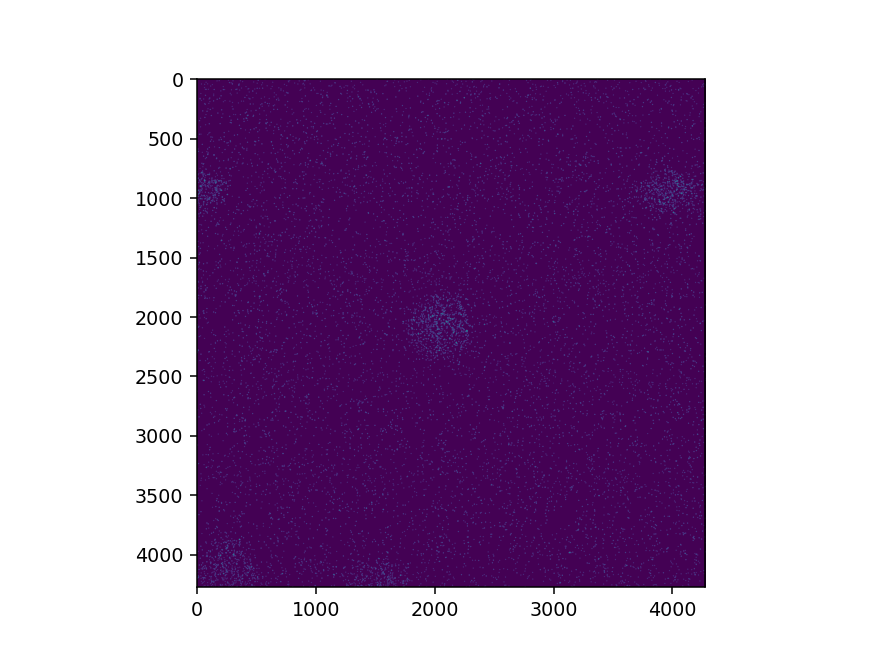

In [95]:
# Calculate circular average
# LxL blocks
pxl_threshold = 80
cnt_threshold = 10
block_length = 16



frame_height = tile_ycnt*ysz
frame_width = tile_xcnt*xsz
reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

tix = 7
zix = 80
print("\rCalculating %d/%d..." % (zix, frame_count), end="")
sys.stdout.flush()
reduced_avg_img = np.zeros((reduced_height, reduced_width))
reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)
t_str = "t%02d" % (tix)
z_str = "z%03d" % (zix)

merged_path = merged_folder + f"{exp_name}_{acq_name}_Merged_{t_str}_{z_str}{channel_str}.tif"
frame = cv2.imread(merged_path)
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
denoised_frame = cv2.fastNlMeansDenoising(frame_gray)
blurred_frame = cv2.GaussianBlur(denoised_frame, (15,15), 0)

fig,ax = plt.subplots(1,1)
ax.imshow(blurred_frame/np.max(blurred_frame))
# _, threshold_frame = cv2.threshold(frame_gray, pxl_threshold, 255, cv2.THRESH_BINARY)
# # blurred_frame = cv2.GaussianBlur(threshold_frame, (15,15), 0)
# blurred_frame = cv2.blur(threshold_frame, (15,15))


# # for yix in range(len(reduced_avg_img)):
# #     for xix in range(len(reduced_avg_img[yix])):
# #         block_img = blurred_frame[yix*block_length:(yix+1)*block_length,
# #                             xix*block_length:(xix+1)*block_length]
# #         reduced_avg_img[yix,xix] = block_img.mean()
# #         reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()
# # np.unique(threshold_frame)
# fig,ax = plt.subplots(1,1)
# ax.hist(blurred_frame[blurred_frame > 0].flatten(), 66)
# _, threshold_frame_2 = cv2.threshold(blurred_frame, 5, 255, cv2.THRESH_BINARY)
# # blurred_frame_2 = cv2.GaussianBlur(threshold_frame_2, (15,15), 0)
# blurred_frame_2 = cv2.blur(threshold_frame_2, (15,15))

# ax.hist(blurred_frame_2[blurred_frame_2 > 5].flatten(), 66)
# ax.imshow(blurred_frame_2/np.max(blurred_frame_2))


<IPython.core.display.Javascript object>


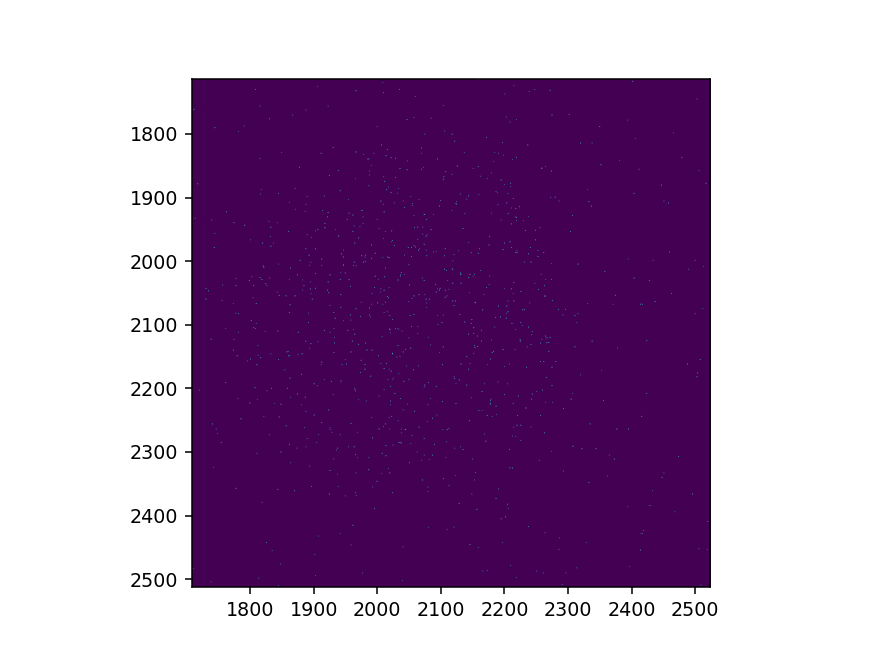

### Central average for the reduced image obtained from full-sized images

<IPython.core.display.Javascript object>


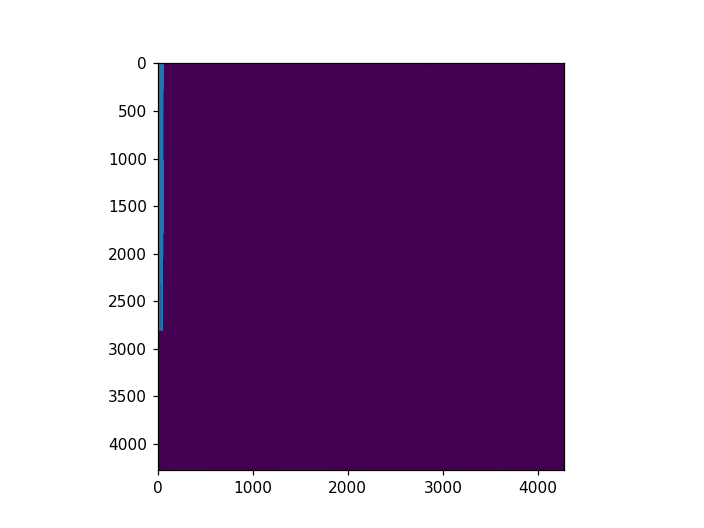

In [19]:
img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
(reduced_height, reduced_width) = img.shape

Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

for Rix in range(len(Rar_pxl)):
    radius = Rar_pxl[Rix]

    circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
    cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
    masked_data = cv2.bitwise_and(img, img, mask=circle_img)

    central_sum[Rix] = masked_data.sum()

# Calculate the uniform fit (polyfit with degree=0)
uniform_fit = np.zeros_like(Rar_pxl[:-1])
for ix in range(len(Rar_pxl[:-1])):
    edge_ix = Rar_pxl[ix]
    uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
    
fig,ax = plt.subplots(1,1)
ax.plot(Rar_pxl[1:], np.diff(central_sum))

# edge_pxl = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
# edge_pxl

### Central average throughout all scanning direcions (z and t)

In [ ]:
# Calculate circular average
# LxL blocks
pxl_threshold = 4
cnt_threshold = 5
block_length = 48
frame_height = tile_ycnt*ysz
frame_width = tile_xcnt*xsz
reduced_height = int(frame_height/block_length)
reduced_width = int(frame_width/block_length)

zar = np.arange(0,frame_count)
tar = np.arange(0,8)
outer_radius_ar = np.zeros((len(tar), len(zar)))
for tix in range(len(tar)):
    t_str = "t%02d" % (tix)
    for zix in range(len(zar)):
        zstrix = zar[zix]
        z_str = "z%03d" % (zstrix)

        print("\rCalculating %d/%d for tix=%d/%d" % (zstrix, frame_count, tix, len(tar)), end="")
        sys.stdout.flush()

        reduced_avg_img = np.zeros((reduced_height, reduced_width))
        reduced_cnt_img = np.zeros_like(reduced_avg_img, dtype=np.int)

        merged_path = merged_folder + f"{exp_name}_{acq_name}_Merged_{t_str}_{z_str}{channel_str}.tif"
        frame = cv2.imread(merged_path)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        for yix in range(len(reduced_avg_img)):
            for xix in range(len(reduced_avg_img[yix])):
                block_img = frame_gray[yix*block_length:(yix+1)*block_length,
                                    xix*block_length:(xix+1)*block_length]
                reduced_avg_img[yix,xix] = block_img.mean()
                reduced_cnt_img[yix,xix] = (block_img > pxl_threshold).sum()

        img = ((reduced_cnt_img > cnt_threshold).astype(np.uint8)*255)
        (reduced_height, reduced_width) = img.shape

        Rar_pxl = np.arange(1,int(reduced_height/2), dtype=np.int) # radius in pixels
        central_sum = np.zeros_like(Rar_pxl, dtype=np.double)

        for Rix in range(len(Rar_pxl)):
            radius = Rar_pxl[Rix]

            circle_img = np.zeros((reduced_height,reduced_width), np.uint8)
            cv2.circle(circle_img,(int(centerx/block_length),int(centery/block_length)), radius,1,thickness=-1)
            masked_data = cv2.bitwise_and(img, img, mask=circle_img)

            central_sum[Rix] = masked_data.sum()

        # Calculate the uniform fit (polyfit with degree=0)
        uniform_fit = np.zeros_like(Rar_pxl[:-1])
        for ix in range(len(Rar_pxl[:-1])):
            edge_ix = Rar_pxl[ix]
            uniform_fit[ix] = np.polyfit(Rar_pxl[edge_ix:], central_sum[edge_ix:], 0)
        # Calculate the uniform fit (polyfit with degree=0)
        try:
            outer_radius_ar[tix, zix] = Rar_pxl[np.abs(np.diff(uniform_fit, prepend=200, append=0)) < 100][0]
        except IndexError:
            outer_radius_ar[tix, zix] = 0

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(outer_radius_ar[7,:])

## Save data to csv

In [ ]:
csv_path = base_folder + f"Resources/{acq_name}_Full.csv"

masked_mean = np.zeros((len(Rar_pxl),frame_count), dtype=np.double)
# flip_masked_mean = np.zeros_like(masked_mean)
# unmasked_mean = np.zeros_like(masked_mean)
# masked_mean = masked_data.sum()/circle_img.sum()
# flip_masked_mean = flip_masked_data.sum()/(1-circle_img).sum()
# unmasked_mean = img.mean()

outer_radius_mm = xsz*tile_xcnt/reduced_height*xvoxel*outer_radius_ar/1e3
zar_mm = zar*zvoxel
df_dict = {"zar (mm)": zar_mm}
for tix in range(len(tar)):
    t_str = "rad_t%d (mm)" % (tix)
    df_dict[t_str] = outer_radius_mm[tix,:]
    
df = pd.DataFrame(data = df_dict)
df.to_csv(csv_path)

df_metadata = pd.DataFrame({"type": "Full-Image",
                            "pxl_threshold": pxl_threshold,
                            "cnt_threshold": cnt_threshold,
                            "centerx": centerx,
                            "centery": centery,
                            "block_length": block_length},
                           index = [0])
df_metadata.to_csv(base_folder + f"Resources/{acq_name}_Full_Metadata.csv")

In [ ]:
pxl_threshold = 4
cnt_threshold = 5
block_length = 48

In [ ]:
pxl_thresholdd

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
percent = np.array([0, 0.2, 0.5, 0.8, 1])
hour = np.array([1, 1, 2, 2, 2, 3, 4])
mint = np.array([29, 49, 9, 35, 58, 33, 6])
time = hour + mint/60.

odlb = np.zeros((len(percent), len(time)))
# 0%
odlb[0,:] = [0.291, 0.455, 0.37*2, np.nan, np.nan, np.nan, np.nan]
odlb[1,:] = [.27, .402, .335*2, np.nan, np.nan, np.nan, np.nan]
odlb[2,:] = [0.182, 0.294, 0.391, 0.353*2, np.nan, np.nan, np.nan]
odlb[3,:] = [0.136, 0.191, 0.272, 0.369, 0.6, np.nan, np.nan]
odlb[4,:] = [0.096, .107, .124, .165, .222, .323, .506]

fig, ax = plt.subplots(1,1)
slopes = np.zeros_like(percent)
for pix in range(len(percent)):
    mask = (np.isnan(odlb[pix,:]) == False)
    p = np.polyfit(time[mask], np.log(odlb[pix,mask]), 1)
    slopes[pix] = p[0]
    
    ax.semilogy(time, odlb[pix,:], 'o')
    

In [ ]:
slopes

In [ ]:
np.log(2)/slopes*60